<a href="https://colab.research.google.com/github/darstech/ML-Foundation/blob/main/notebooks/regression_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref: [John Krohn Github](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb)

# Regression in Tensorflow

In this notebook, we use the PyTorch **automatic differentiation** library to fit a straight line to data points. Thus, here we use calculus to solve the same regression problem that we used the Moore-Penrose Pseudoinverse to solve in the [*Linear Algebra II* notebook](https://github.com/darstech/ML-Foundation/blob/main/2_linear_algebra_ii.ipynb).

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.]) # E.g.: Dosage of drug for treating Alzheimer's disease
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

The $y$ values were created using the equation of a line $y = mx + b$. This way, we know what the model parameters to be learned are, say, $m = -0.5$ and $b = 2$. Random, normally-distributed noise has been added to simulate sampling error: 

In [3]:
# y = -0.5*x + 2 + torch.normal(mean=torch.zeros(8), std=0.2)

For reproducibility of this demo, here's a fixed example of $y$ values obtained by running the commented-out line above: 

In [4]:
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]) # E.g.: Patient's "forgetfulness score"
y

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

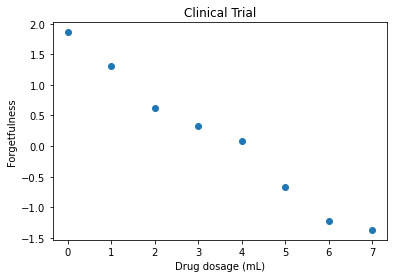

In [5]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
_ = ax.scatter(x, y)

Initialize the slope parameter $m$ with a "random" value of 0.9...

(**N.B.**: In this simple demo, we could guess approximately-correct parameter values to start with. Or, we could use an algebraic (e.g., Moore-Penrose pseudoinverse) or statistical (e.g., ordinary-least-squares regression) to solve for the parameters quickly. This tiny machine learning demo with two parameters and eight data points scales, however, to millions of parameters and millions of data points. The other approaches -- guessing, algebra, statistics -- do not come close to scaling in this way.)

In [6]:
m = torch.tensor([0.9]).requires_grad_()
m

tensor([0.9000], requires_grad=True)

...and do the same for the $y$-intercept parameter $b$: 

In [7]:
b = torch.tensor([0.1]).requires_grad_()
b

tensor([0.1000], requires_grad=True)

In [8]:
def regression(my_x, my_m, my_b):
    return my_m*my_x + my_b

In [9]:
def regression_plot(my_x, my_y, my_m, my_b):
    
    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)
    
    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b).detach().item()
    y_max = regression(x_max, my_m, my_b).detach().item()
    
    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max])

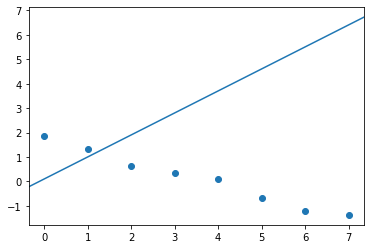

In [10]:
regression_plot(x, y, m, b)

### Machine Learning
In four easy steps

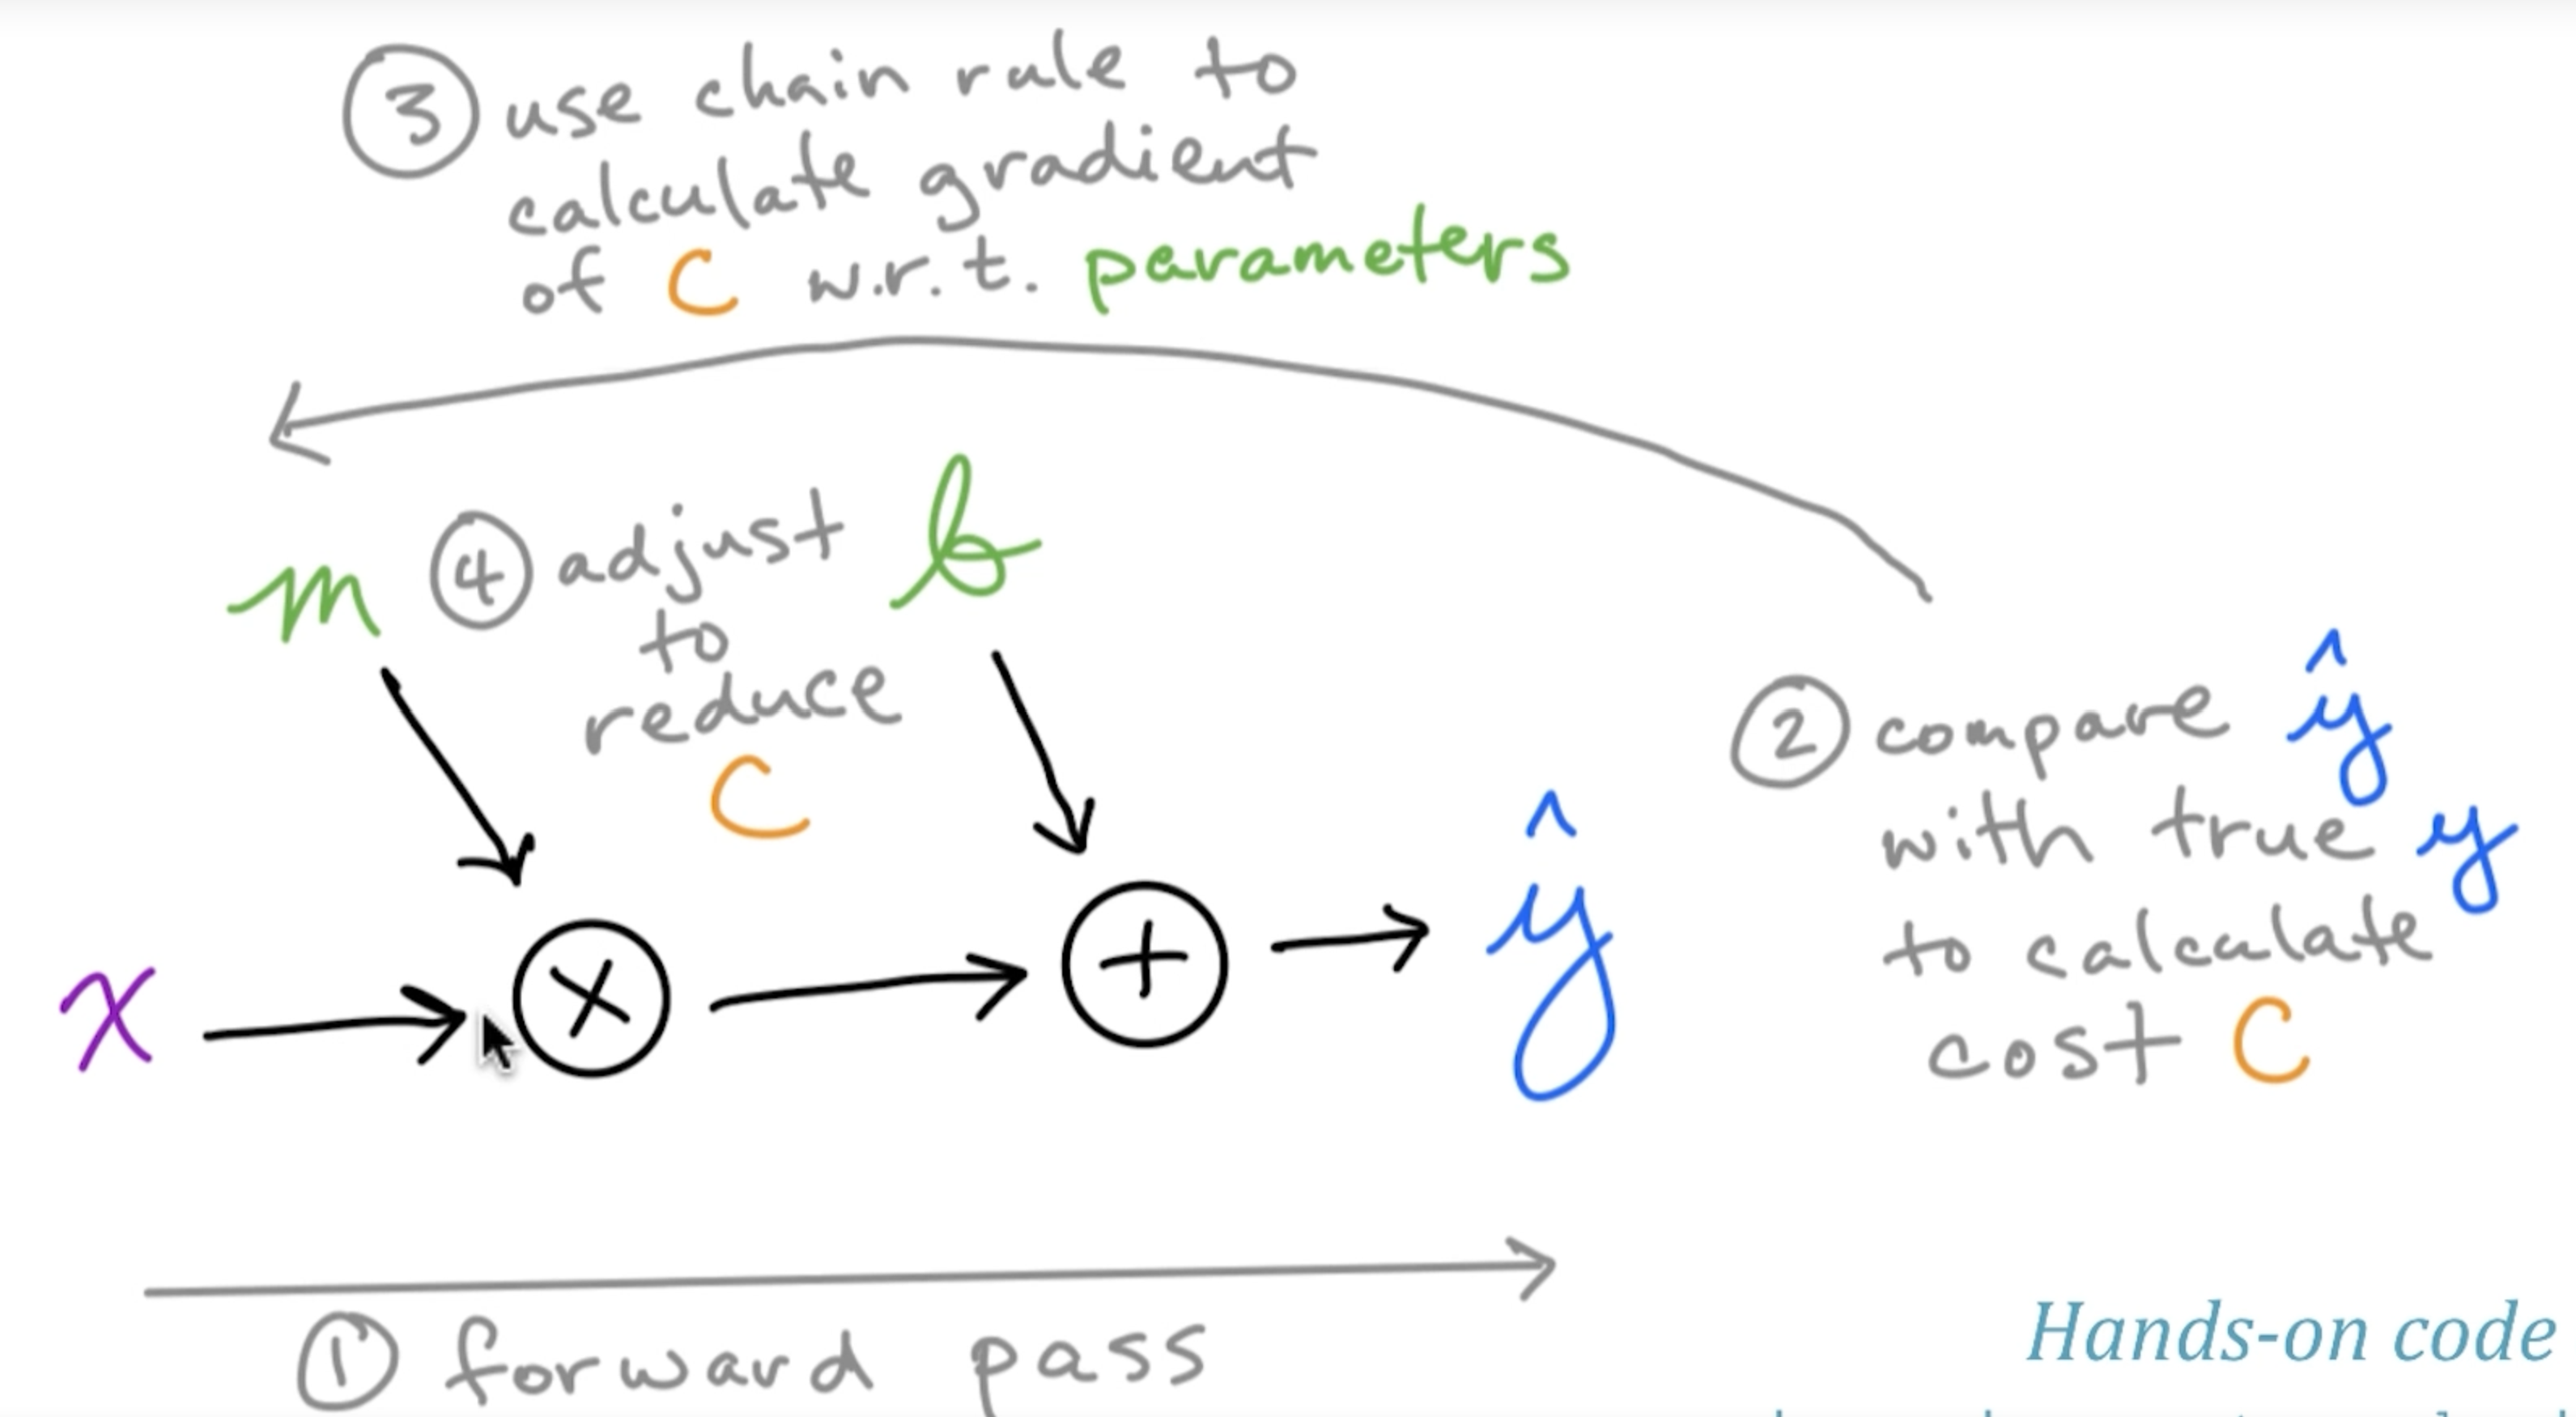

**Step 1**: Forward pass

In [11]:
yhat = regression(x, m, b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$

There is a PyTorch `MSELoss` method, but let's define it outselves to see how it works. MSE cost is defined by: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [12]:
def mse(yhat, my_y):
  sigma = torch.sum((yhat - my_y)**2)
  return sigma/len(my_y)


In [13]:
C = mse(yhat, y)
C

tensor(19.6755, grad_fn=<DivBackward0>)

**Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [14]:
C.backward()

In [15]:
# gradient of slope attribute
m.grad

#Derivative of C(i.e. C) w.r.t to model parameter m is 36.3050 --> positve slope between them which means reducing m will correspondent to reduction in C
#

tensor([36.3050])

In [16]:
b.grad

# Slope of C w.r.t b is positive (i.e. 6.2650) as well. which means positive relationshion between Cost and 
# model parameter b and reducing b would correspondent to reduction in Cost (C)

tensor([6.2650])

Slope ($[36.3050]$) is much larger for Cost (C) w.r.t to m, compared to Cost w.r.t b (i.e.g $[6.2650]$); which means reduction in m will have bigger impact on Cost

**Step 4**: Gradient descent

In [17]:
# Initialize Optimizer
optimizer = torch.optim.SGD([m, b], lr=0.01)

In [18]:
optimizer.step()

Confirm parameters have been adjusted sensibly:

In [19]:
m

tensor([0.5369], requires_grad=True)

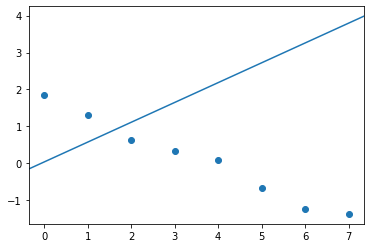

In [20]:
regression_plot(x, y, m, b)

line still doesn't fit data points. We can repeat steps 1 & 2 to confirm cost has decreased:

In [21]:
C = mse(regression(x, m, b), y)
C

tensor(8.5722, grad_fn=<DivBackward0>)

Put the 4 steps in a loop to iteratively minimize cost towards zero:

In [22]:
epochs = 1000
for epoch in range(epochs):

  optimizer.zero_grad() # Reset gradients to zero; else they accumulate

  # Step - 1
  yhat = regression(x, m, b) 

  # Step - 2
  C = mse(yhat, y)

  # Step - 3
  C.backward()

  # Step - 4
  optimizer.step()

  print('Epoch {}, cost {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))

Epoch 0, cost 8.57, m grad 23.2, b grad 3.6
Epoch 1, cost 4.08, m grad 14.8, b grad 1.91
Epoch 2, cost 2.25, m grad 9.49, b grad 0.831
Epoch 3, cost 1.51, m grad 6.11, b grad 0.15
Epoch 4, cost 1.2, m grad 3.96, b grad -0.28
Epoch 5, cost 1.07, m grad 2.59, b grad -0.552
Epoch 6, cost 1.01, m grad 1.72, b grad -0.723
Epoch 7, cost 0.981, m grad 1.17, b grad -0.829
Epoch 8, cost 0.962, m grad 0.82, b grad -0.894
Epoch 9, cost 0.948, m grad 0.595, b grad -0.934
Epoch 10, cost 0.936, m grad 0.452, b grad -0.957
Epoch 11, cost 0.925, m grad 0.361, b grad -0.969
Epoch 12, cost 0.915, m grad 0.302, b grad -0.975
Epoch 13, cost 0.904, m grad 0.265, b grad -0.977
Epoch 14, cost 0.894, m grad 0.241, b grad -0.976
Epoch 15, cost 0.884, m grad 0.225, b grad -0.973
Epoch 16, cost 0.874, m grad 0.214, b grad -0.969
Epoch 17, cost 0.864, m grad 0.207, b grad -0.965
Epoch 18, cost 0.854, m grad 0.202, b grad -0.96
Epoch 19, cost 0.845, m grad 0.199, b grad -0.955
Epoch 20, cost 0.835, m grad 0.196, b

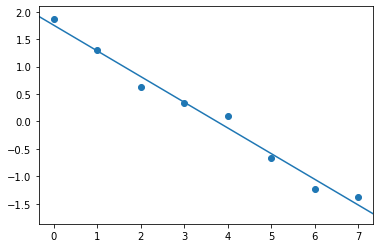

In [23]:
regression_plot(x, y, m, b)

In [24]:
m.item()

-0.4681258499622345

In [25]:
b.item()

1.7542961835861206